In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
%matplotlib inline
from astropy.table import Table


In [18]:
tab = Table.read('Data/SN1987A_photometry.csv',format='ascii')
band = tab['band']
time = tab['time']
mag = tab['magnitude']
band_name = np.unique(band)
tab

event,time,magnitude,e_magnitude,upperlimit,band,instrument,telescope,source
str7,float64,float64,int64,int64,str1,int64,int64,str104
SN1987A,46849.44,6.36,--,--,V,--,--,"1987IAUC.4495....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46849.62,6.11,--,--,V,--,--,"1987IAUC.4495....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.89,--,--,B,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.06,--,--,U,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.45,4.81,--,--,V,--,--,"1987IAUC.4313....1M,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.74,--,--,B,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.29,--,--,I,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,4.37,--,--,R,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"
SN1987A,46850.8,3.95,--,--,U,--,--,"1987IAUC.4320....1F,Sternberg Astronomical Institute Supernova Light Curve Catalogue"


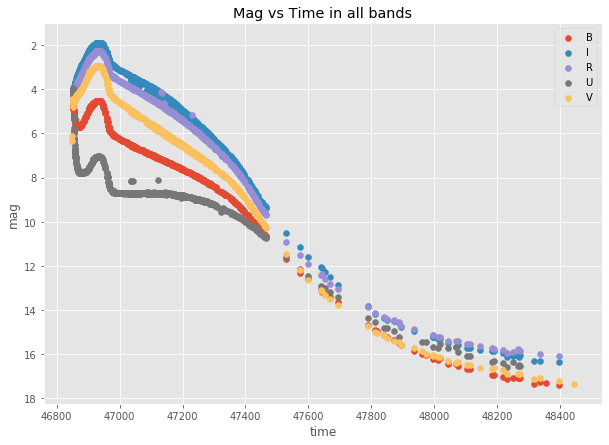

In [27]:
plt.style.use('ggplot')
plt.figure(figsize = (10,7))
for i in range(len(band_name)):
    plt.scatter(time[band == band_name[i]], mag[band == band_name[i]], label = str(band_name[i]))
    plt.legend()
plt.title("Mag vs Time in all bands")
plt.xlabel("time") 
plt.ylabel("mag")
plt.gca().invert_yaxis()

In [100]:
mask = (time>46800) & (time < 46980)
mtab = tab[mask]
mtime = mtab['time']
mmag = mtab['magnitude']
mband = mtab['band']
min_time = np.min(mtime)
mtime = mtime - min_time # to make time start from zero

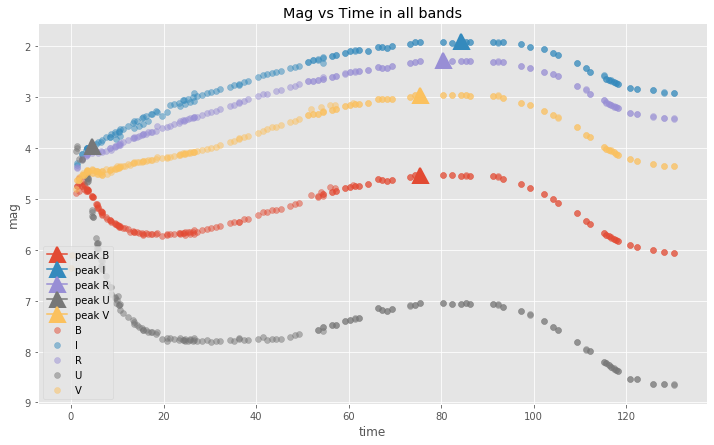

In [101]:
plt.style.use('ggplot')
plt.figure(figsize = (12,7))
for i in range(len(band_name)):
    plt.scatter(mtime[mband == band_name[i]], mmag[mband == band_name[i]], label = str(band_name[i]), alpha = 0.5)
    #min_index = np.argmin(mmag[mband == band_name[i]])
    min_mag = np.min(mmag[mband == band_name[i]])
    plt.plot(np.median(mtime[mmag == min_mag]), min_mag , marker ='^', label = 'peak ' + str(band_name[i]), ms=15.,  mew=2)
    plt.legend(loc = 'best')
plt.title("Mag vs Time in all bands")
plt.xlabel("time") 
plt.ylabel("mag")
plt.gca().invert_yaxis()
